# Data Inspection

## General

### Imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from pathlib import Path
import os

%matplotlib inline
sns.set_style("whitegrid")

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')  # tokenizer
nltk.download('stopwords') 
nltk.download('wordnet')    # lemmatization
nltk.download('omw-1.4')    # include different languages
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt_tab to /home/tiggi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tiggi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tiggi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tiggi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tiggi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Globals

In [62]:
COLOR_MAP = "viridis" #"Greens" 

plt.rcParams["image.cmap"] = COLOR_MAP
sns.set_theme(style="whitegrid", palette= COLOR_MAP) 

current_dir = Path(os.getcwd()).resolve().parent
RAW_DATA_PATH = current_dir / "data" / "SMSSpamCollection.csv"

### Load

In [63]:
data = pd.read_csv(RAW_DATA_PATH, delimiter='\t', header=None, encoding='utf-8')

In [64]:
data = data.rename(columns={0: 'label', 1: 'msg_text'})
data.head()

,label,msg_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [65]:
data.shape

(5572, 2)

## Data Exploration

### Descriptive Stats

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5572 non-null   object
 1   msg_text  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [67]:
# describe data:
data.describe()

,label,msg_text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


> we found that most of the data is 'ham', only 747/5572 (13.4%) is labeled as spam, which should represent bias in the dataset, that should be accounted for by the model. 
> additionally, there are 5,169 unique values leaving around 400 repeating messages. 

/tmp/ipykernel_83235/1010261006.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(COLOR_MAP)


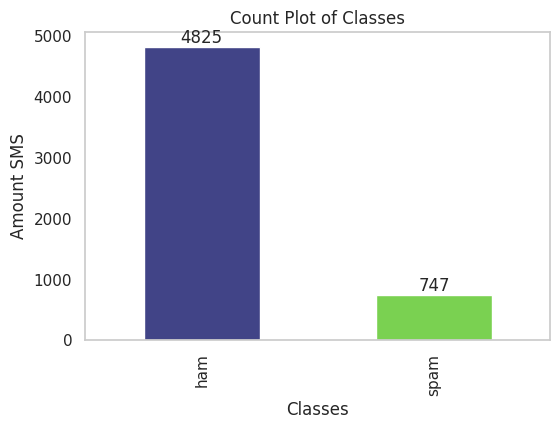

In [68]:
# plot class distirbution 

# set color
cmap = plt.cm.get_cmap(COLOR_MAP)
colors = [cmap(0.2), cmap(0.8)]

data['label'].value_counts().plot(kind='bar', figsize=(6, 4), color=colors)

# title and labels
plt.title("Count Plot of Classes")
plt.xlabel("Classes")
plt.ylabel("Amount SMS")
plt.grid()


# count labels on top 
for i, v in enumerate(data['label'].value_counts()):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=12)

plt.show()

In [72]:
# check the distribution of the non-unique messages: 
repeating_messages = data.groupby('label').describe()
#repeating_messages['unique_percent'] = repeating_messages[('msg_text', 'unique')] / repeating_messages[('msg_text', 'unique')].sum()
repeating_messages[('msg_text', 'unique')] / repeating_messages[('msg_text', 'unique')].sum()

label
ham     0.87367
spam    0.12633
Name: (msg_text, unique), dtype: object

> the distribution of the non-unique messages are almost the same as the distribution of the classes in the entire database. 

> one specific text message do appear most in both classes. but the text is also reasonable for the class. 

> 'sorry I'll call later' is in many cases an auto-suggested sms text by many phone providers. 

Text(0.5, 1.0, 'Length Distribution per SMS Class')

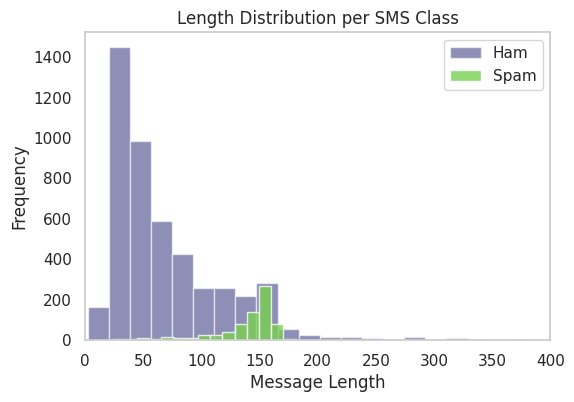

In [48]:
# distributions of message lengths by class: 

data['msg_len'] = data.msg_text.apply(len)

plt.figure(figsize=(6, 4))

data[data.label=='ham'].msg_len.plot(bins=50, kind='hist', color=cmap(0.2), 
                                       label='Ham', alpha=0.6)
data[data.label=='spam'].msg_len.plot(bins=20, kind='hist', color=cmap(0.8), 
                                       label='Spam', alpha=0.8)
plt.legend()
plt.grid()
plt.xlim((0,400))
plt.xlabel("Message Length")
plt.title('Length Distribution per SMS Class')

> the histogram shows a wider distribution of the length of the 'ham' messages, relative to the 'spam'. 
> spam messages tend to be longer than the ham messages.
> the description below shows an even wider distribution, that is not shown on the histogram, reaching up to 910 characters. 

In [49]:
print('Ham Class:')
data[data['label']=='ham'].describe()

Ham Class:


,msg_len
count,4825.000000
mean,71.482487
std,58.440652
min,2.000000
25%,33.000000
50%,52.000000
75%,93.000000
max,910.000000


In [50]:
print('Spam Class:')
data[data['label']=='spam'].describe()

Spam Class:


,msg_len
count,747.000000
mean,138.670683
std,28.873603
min,13.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,223.000000


> for 'ham' messages, both the length mean and std are higher than 'spam', although interesting that the 75% of the spam is higher than the one from the ham. 
This is probably due to the outlier of 910 characters in the longest message of the ham. 

In [51]:
data['msg_len'].nlargest(15)

1085    910
1863    790
2434    629
1579    611
2158    588
2849    588
2380    482
3017    461
1513    458
2370    446
5104    446
2408    444
2681    444
3280    444
2010    431
Name: msg_len, dtype: int64

> there are many relatively long messages, ,much longer than the average. therefore these outliers cannot be treated as single event and must be handled for the model. 

In [52]:
data["number_words"] = data.apply(lambda row: nltk.word_tokenize(row["msg_text"]), axis=1).apply(len)
data["number_sentences"] = data.apply(lambda row: nltk.sent_tokenize(row["msg_text"]), axis=1).apply(len)
data

,label,msg_text,msg_len,number_words,number_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,35,4
5568,ham,Will ü b going to esplanade fr home?,36,9,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1


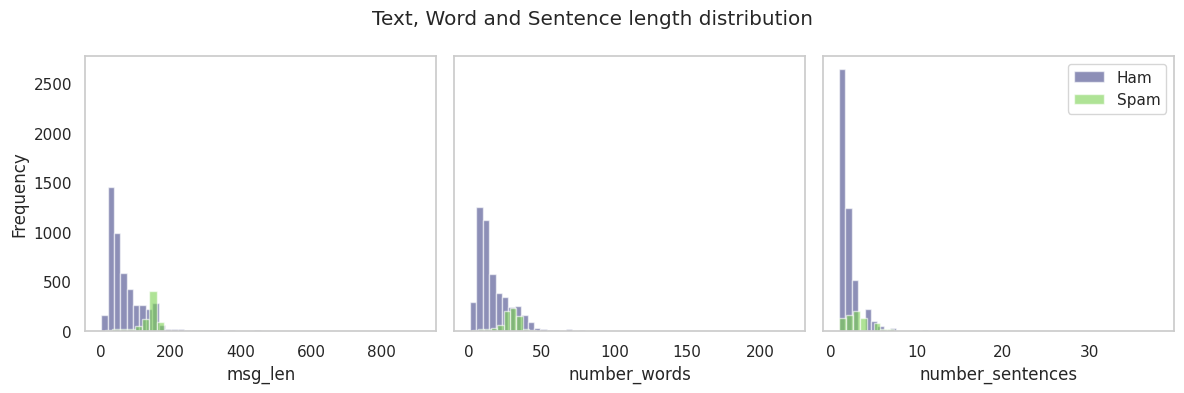

In [53]:
fig, ax = plt.subplots(1,3, figsize=(12, 4), sharey=True)
plt.suptitle('Text, Word and Sentence length distribution')
cols = data.columns[-3:].to_list()

for i, col in enumerate(cols):

    data[data.label=='ham'][col].plot(bins=50, kind='hist', color=cmap(0.2), 
                                       label='Ham', alpha=0.6, ax=ax[i])
    data[data.label=='spam'][col].plot(kind='hist', color=cmap(0.8), 
                                        label='Spam', alpha=0.6, ax=ax[i])
    ax[i].set_xlabel(f"{col}")
    ax[i].grid()
    
plt.legend()

plt.tight_layout()
plt.show()

> similarly, number of words also shows to be higher for 'spam' messages, around the mean, with outliers unseen in the plot. same behavior of sentences, 
where the differences are more distinct but but the mean of both ham and spam do not seem to be so far away from another

<Figure size 1200x800 with 0 Axes>

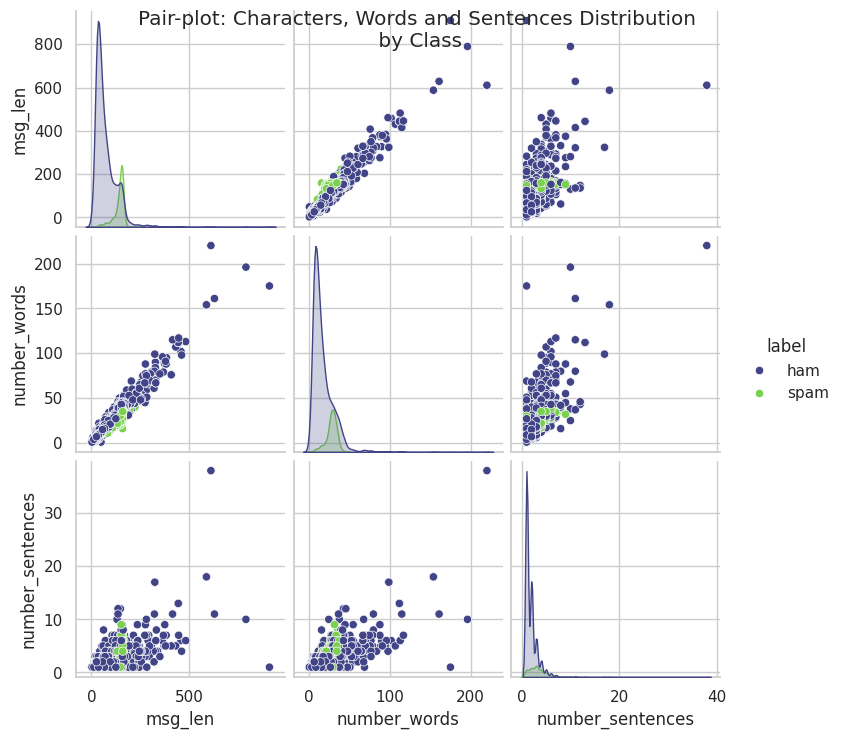

In [54]:
# check correlation patterns with pair-plots: 
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="label",palette=colors)
plt.suptitle(f'Pair-plot: Characters, Words and Sentences Distribution\n by Class')
plt.show(fg)

most or all of the outliers are from the class ham, not spam. These can be used for the classification

### Most Common words

In [55]:
# clean text

def clean_special_chars(text):
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.split()
    clean_text = ' '.join(text)
    
    return clean_text

data['clean_text'] = data['msg_text'].apply(clean_special_chars)
data["tokenized_text"]=data.apply(lambda row: nltk.word_tokenize(row["clean_text"]), axis=1)



In [56]:
# remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["stopword_clean_text"] = data["tokenized_text"].apply(remove_stopwords)


In [57]:
# lemmatization

lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["lemmatized_text"] = data["stopword_clean_text"].apply(lemmatize_word)

data

,label,msg_text,msg_len,number_words,number_sentences,clean_text,tokenized_text,stopword_clean_text,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, live, around, though]"
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,35,4,this is the nd time we have tried contact u u ...,"[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, u, pound, prize,...","[nd, time, try, contact, u, u, pound, prize, c..."
5568,ham,Will ü b going to esplanade fr home?,36,9,1,will b going to esplanade fr home,"[will, b, going, to, esplanade, fr, home]","[b, going, esplanade, fr, home]","[b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,pity was in mood for that soany other suggestions,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[pity, mood, soany, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som..."


In [58]:
from collections import Counter

words_hamlist = data[data.label=='ham'].lemmatized_text.apply(lambda x: [word.lower() for word in x])
words_spamlist = data[data.label=='spam'].lemmatized_text.apply(lambda x: [word.lower() for word in x])
ham_words = Counter()
spam_words = Counter()
for hmsg, smsg in zip(words_hamlist, words_spamlist):
    ham_words.update(hmsg)
    spam_words.update(smsg)
    
print(f'ham most frequent words: \n{ham_words.most_common(50)}')
print(f'spam most frequent words: \n{spam_words.most_common(50)}')

ham most frequent words: 
[('u', 135), ('get', 97), ('go', 76), ('im', 64), ('call', 53), ('like', 48), ('know', 44), ('say', 43), ('dont', 42), ('time', 41), ('ill', 40), ('come', 40), ('ok', 38), ('ltgt', 36), ('send', 36), ('need', 33), ('want', 32), ('day', 32), ('take', 31), ('sorry', 31), ('good', 31), ('think', 30), ('miss', 28), ('love', 27), ('tell', 27), ('see', 27), ('make', 26), ('give', 26), ('great', 25), ('well', 25), ('home', 24), ('thats', 23), ('ur', 23), ('still', 23), ('hi', 23), ('cant', 22), ('dear', 20), ('already', 19), ('way', 19), ('meet', 19), ('hope', 19), ('later', 19), ('even', 18), ('today', 18), ('work', 18), ('ask', 18), ('much', 18), ('one', 18), ('na', 17), ('finish', 17)]
spam most frequent words: 
[('call', 369), ('free', 219), ('u', 155), ('txt', 151), ('ur', 144), ('mobile', 124), ('text', 121), ('stop', 118), ('claim', 115), ('reply', 110), ('prize', 94), ('get', 94), ('send', 80), ('p', 73), ('tone', 73), ('service', 72), ('nokia', 69), ('new', 

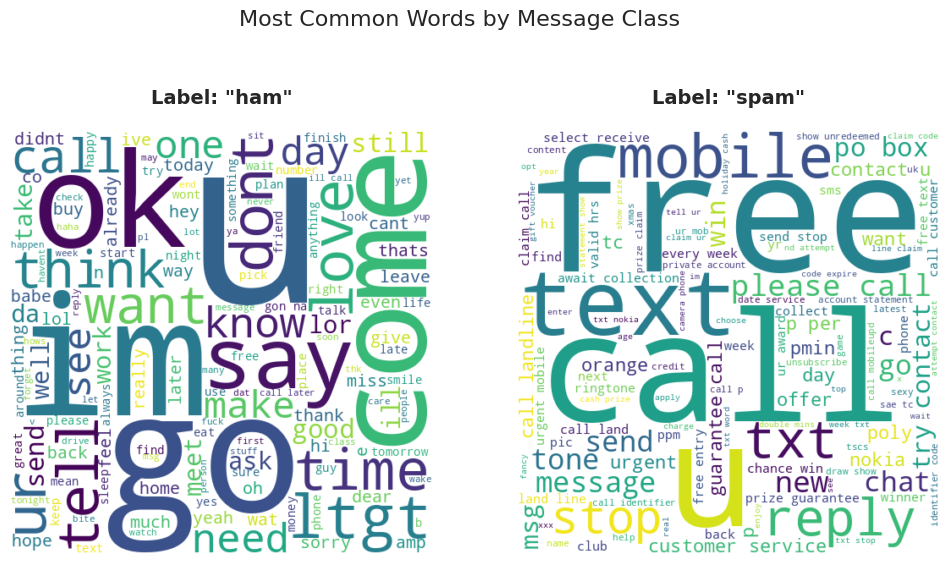

In [59]:
# word cloud
data["lemmatized_text_str"] = data["lemmatized_text"].apply(lambda tokens: " ".join(tokens))

fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('Most Common Words by Message Class', fontsize=16, y=1.05)

for i,l in enumerate(data['label'].unique().tolist()):
    text = data[data['label'] == l]['lemmatized_text_str'].str.cat(sep=" ")
    wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
    spam_wc = wc.generate(text)

    ax[i].imshow(spam_wc, interpolation='bilinear')
    ax[i].axis("off")
    ax[i].set_title(f'Label: "{l}"', pad=20,  fontsize=14, fontweight="bold")
plt.show()

/tmp/ipykernel_83235/78000815.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], ax=ax[i], palette=COLOR_MAP)
/tmp/ipykernel_83235/78000815.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], ax=ax[i], palette=COLOR_MAP)


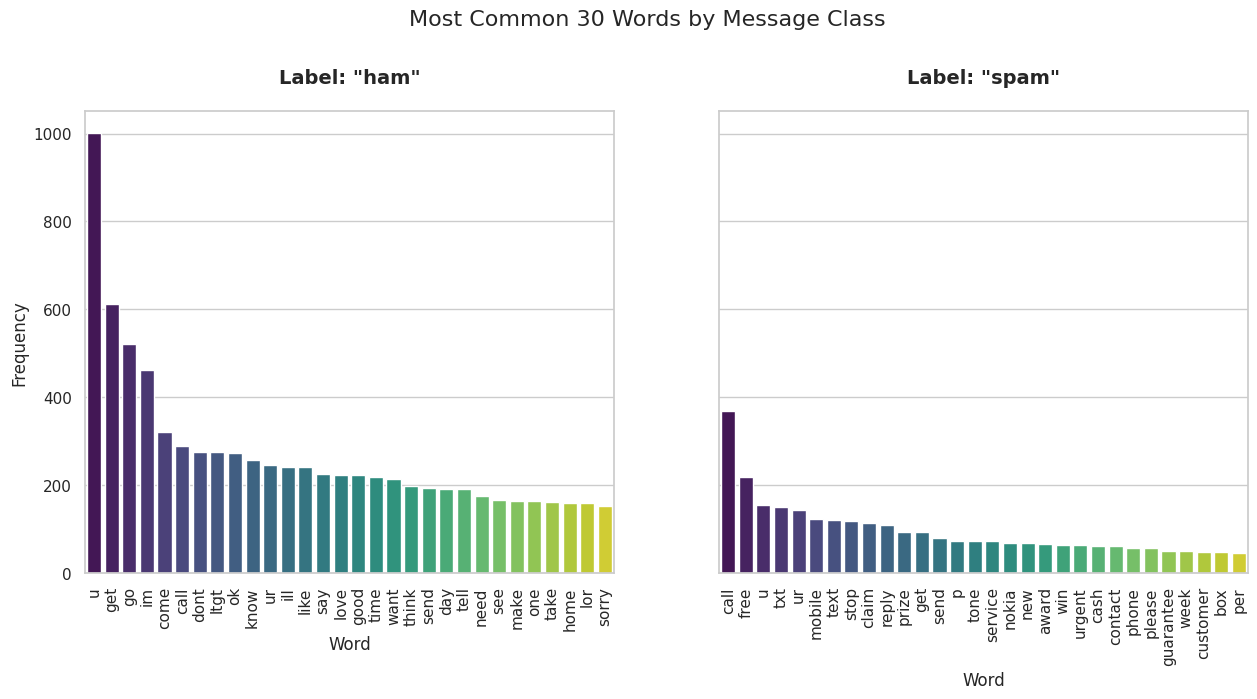

In [60]:
# a different view: 

fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
fig.suptitle('Most Common 30 Words by Message Class', fontsize=16, y=1.05)

for i,l in enumerate(data['label'].unique().tolist()):

    spam_corpus = []
    for sentence in data[data['label'] == l]['lemmatized_text'].tolist():
        for word in sentence:
            spam_corpus.append(word)

    filter_df = pd.DataFrame(Counter(spam_corpus).most_common(30))
    sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], ax=ax[i], palette=COLOR_MAP)
    ax[i].set_title(f'Label: "{l}"', pad=20,  fontsize=14, fontweight="bold")
    ax[i].tick_params(axis="x", rotation=90)
    ax[i].set_xlabel('Word')
    ax[i].set_ylabel('Frequency')
plt.show()
